# Function / Data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy
from google.colab import drive
import os
import torch.nn.functional as F
import random
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/adonet_data')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 작업 디렉토리: {os.getcwd()} 현재 디바이스: {device}")
pd.set_option('display.max_rows',    None)
pd.set_option('display.max_columns', None)

cntset = pd.read_csv('Connectome.csv')

X_ann = pd.read_csv('DoOR_RNN.csv')

Mounted at /content/drive
현재 작업 디렉토리: /content/drive/MyDrive/adonet_data 현재 디바이스: cuda


# Weight(mask) processing

Neuron ID

In [2]:
#ORN 전체ID
orn_pre=cntset[(cntset["pre_class"]=='ORN')]['pre_root_id']
orn_post = cntset[(cntset["post_class"]=='ORN')]['post_root_id']
ORN_ids = pd.concat([orn_pre, orn_post]).unique()
len(ORN_ids)

2279

In [3]:
#ALPN 전체ID
ALPN_pre=cntset[(cntset["pre_class"]=='ALPN')]['pre_root_id']
ALPN_post = cntset[(cntset["post_class"]=='ALPN')]['post_root_id']
ALPN_ids = pd.concat([ALPN_pre, ALPN_post]).unique()
len(ALPN_ids)

684

In [4]:
#KC 전체ID
KC_pre=cntset[(cntset["pre_class"]=='KC')]['pre_root_id']
KC_post = cntset[(cntset["post_class"]=='KC')]['post_root_id']
KC_ids = pd.concat([KC_pre, KC_post]).unique()
len(KC_ids)

5177

Feedback mask

In [5]:
#KC TO ALPN FEEDBACK MASK
fb=cntset[cntset["directionality"]=='feedback']
ktp = fb[(fb["pre_class"]=='KC') & (fb["post_class"]=='ALPN')]
ktp1 = pd.crosstab(
    index= ktp['pre_root_id'],
    columns= ktp['post_root_id']
    , values= ktp['syn_count'],
    aggfunc='sum'
).fillna(0)
print(ktp1.shape)

mask_ktp = ktp1.reindex(index=KC_ids, columns=ALPN_ids, fill_value=0)
mask_ktp.shape

(2664, 300)


(5177, 684)

In [6]:
#ALPN TO ORN FEEDBACK MASK
fb=cntset[cntset["directionality"]=='feedback']
pto = fb[(fb["pre_class"]=='ALPN') & (fb["post_class"]=='ORN')]
pto1 = pd.crosstab(
    index= pto['pre_root_id'],
    columns= pto['post_root_id']
    , values= pto['syn_count'],
    aggfunc='sum'
).fillna(0)
print(pto1.shape)

mask_pto = pto1.reindex(index=ALPN_ids, columns=ORN_ids, fill_value=0)
mask_pto.shape

(439, 1935)


(684, 2279)

In [7]:
#KC TO ORN FEEDBACK MASK
fb=cntset[cntset["directionality"]=='feedback']
kto = fb[(fb["pre_class"]=='KC') & (fb["post_class"]=='ORN')]
kto1 = pd.crosstab(
    index= kto['pre_root_id'],
    columns= kto['post_root_id']
    , values= kto['syn_count'],
    aggfunc='sum'
).fillna(0)
print(kto1.shape)

mask_kto = kto1.reindex(index=KC_ids, columns=ORN_ids, fill_value=0)
mask_kto.shape

(0, 0)


(5177, 2279)

Lateral mask

In [8]:
#ORN TO ORN LATERAL MASK
lt=cntset[cntset["directionality"]=='self']
oto = lt[(lt["pre_class"]=='ORN') & (lt["post_class"]=='ORN')]
oto1 = pd.crosstab(
    index= oto['pre_root_id'],
    columns= oto['post_root_id']
    , values= oto['syn_count'],
    aggfunc='sum'
).fillna(0)
print(oto1.shape)

mask_oto = oto1.reindex(index=ORN_ids, columns=ORN_ids, fill_value=0)
mask_oto.shape

(2277, 2276)


(2279, 2279)

In [9]:
#PN TO PN LATERAL MASK
lt=cntset[cntset["directionality"]=='self']
ptp = lt[(lt["pre_class"]=='ALPN') & (lt["post_class"]=='ALPN')]
ptp1 = pd.crosstab(
    index= ptp['pre_root_id'],
    columns= ptp['post_root_id']
    , values= ptp['syn_count'],
    aggfunc='sum'
).fillna(0)
print(ptp1.shape)

mask_ptp = ptp1.reindex(index=ALPN_ids, columns=ALPN_ids, fill_value=0)
mask_ptp.shape

(684, 684)


(684, 684)

In [10]:
#KC TO KC LATERAL MASK
lt=cntset[cntset["directionality"]=='self']
ktk = lt[(lt["pre_class"]=='KC') & (lt["post_class"]=='KC')]
ktk1 = pd.crosstab(
    index= ktk['pre_root_id'],
    columns= ktk['post_root_id']
    , values= ktk['syn_count'],
    aggfunc='sum'
).fillna(0)
print(ktk1.shape)

mask_ktk = ktk1.reindex(index=KC_ids, columns=KC_ids, fill_value=0)
mask_ktk.shape

(5177, 5177)


(5177, 5177)

Feedforward mask

In [11]:
#ORN TO ALPN FEEDFORWARD MASK
ff=cntset[cntset["directionality"]=='feedforward']
otp = ff[(ff["pre_class"]=='ORN') & (ff["post_class"]=='ALPN')]
otp1 = pd.crosstab(
    index= otp['pre_root_id'],
    columns= otp['post_root_id']
    , values= otp['syn_count'],
    aggfunc='sum'
).fillna(0)
print(otp1.shape)

mask_otp = otp1.reindex(index=ORN_ids, columns=ALPN_ids, fill_value=0)
mask_otp.shape

(2278, 615)


(2279, 684)

In [12]:
#ALPN TO KC FEEDFORWARD MASK
ff=cntset[cntset["directionality"]=='feedforward']
ptk = ff[(ff["pre_class"]=='ALPN') & (ff["post_class"]=='KC')]
ptk1 = pd.crosstab(
    index= ptk['pre_root_id'],
    columns= ptk['post_root_id']
    , values= ptk['syn_count'],
    aggfunc='sum'
).fillna(0)
print(ptk1.shape)

mask_ptk = ptk1.reindex(index=ALPN_ids, columns=KC_ids, fill_value=0)
mask_ptk.shape

(334, 4907)


(684, 5177)

# DoOR data input

In [13]:
cls_labels = []
for i in range(250):
    cls_labels.append(f'Odor_({i+1})')

le = LabelEncoder()
y_int = le.fit_transform(cls_labels)
y = y_int
y_out = torch.tensor(y, dtype=torch.long)

x_train = []
y_train = []
x_test = []
y_test = []

arr_train = np.arange(250)
arr2_train = np.tile(arr_train, 8)
np.random.shuffle(arr2_train)

for n in arr2_train:
    noise = torch.normal(mean=0, std=0.2, size=(2279,))
    xi = pd.to_numeric(X_ann.iloc[n, 1:], errors='coerce')
    xn = torch.zeros(2279, dtype=torch.float32)
    xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
    x_train.append(xn)
    y_train.append(y_out[n])

arr_test = np.arange(250)
arr2_test = np.tile(arr_test, 2)
np.random.shuffle(arr2_test)

for k in arr2_test:
    noise = torch.normal(mean=0, std=0.2, size=(2279,))
    xi = pd.to_numeric(X_ann.iloc[k, 1:], errors='coerce')
    xn = torch.zeros(2279, dtype=torch.float32)
    xn = torch.tensor(xi.fillna(0).values, dtype=torch.float32) + noise
    x_test.append(xn)
    y_test.append(y_out[k])

x_train = torch.stack(x_train).to(dtype=torch.float32)
y_train = torch.stack(y_train).to(dtype=torch.long)
x_test = torch.stack(x_test).to(dtype=torch.float32)
y_test = torch.stack(y_test).to(dtype=torch.long)

train_ds = TensorDataset(x_train, y_train)
test_ds  = TensorDataset(x_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)


# MODEL

In [14]:
def normalize_syn(S , mode ='fanin', eps=1e-8): # 정규화(weight initialization) 방식 선택

    if mode == 'fanin' : # 각 열(input)로 들어오는 합 = 1
        col_sum = S.sum(dim=0, keepdim=True) + eps
        return S / col_sum

    else:
        s_max = S.max() # max로 나누기
        return S / s_max

class MaskedParamWithSyn(nn.Module): # 전처리한 데이터인 mask들을 weight로 사용

    def __init__(self, S_counts ,device=None):
        super().__init__()
        S = torch.as_tensor(S_counts, dtype=torch.float32, device=device) #버퍼 및 parameter로 등록되지 않은 텐서는 위치를 지정해줘야됨 gpu 로 자동이동되지 않기
        M = (S != 0).float()
        self.register_buffer('mask', M)
        with torch.no_grad():
            S_norm = normalize_syn(S * M, mode = 'fanin')  # weight 초기화 방법 입력
        self.register_buffer('S_norm', S_norm)
        # 학습 파라미터 설정(실제 학습이 일어나는 부분)
        self.delta = nn.Parameter(torch.zeros_like(S_norm))

    def weight(self):
        W = self.S_norm + self.delta
        return W * self.mask  # (n_src, n_dst)

    def forward(self, x):  # x: (B, n_src) -> (B, n_dst)
        return x @ self.weight() # def step 에서 계산부분

class ADOnetRNN(nn.Module):
    def __init__(self, S_otp, S_ptk, S_ktp, S_pto, S_oto, S_ptp, S_ktk, S_kto,
                 T=8, device=None): #None 자리 입력해도되고 안해도 됨
        super().__init__()
        self.T = T  # timestep
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # mask를 weight로 사용
        self.W_otp  = MaskedParamWithSyn(S_otp, device=self.device)  # ORN->PN
        self.W_ptk  = MaskedParamWithSyn(S_ptk, device=self.device)  # PN->KC
        self.W_kto  = MaskedParamWithSyn(S_kto, device=self.device)  # KC->ORN
        self.W_ktp  = MaskedParamWithSyn(S_ktp, device=self.device)  # KC->PN
        self.W_pto  = MaskedParamWithSyn(S_pto, device=self.device)  # PN->ORN
        self.W_oto  = MaskedParamWithSyn(S_oto, device=self.device)  # ORN->ORN
        self.W_ptp  = MaskedParamWithSyn(S_ptp, device=self.device)  # PN->PN
        self.W_ktk  = MaskedParamWithSyn(S_ktk, device=self.device)  # KC->KC

        # 차원 추론
        n_orn = S_otp.shape[0]
        n_pn  = S_otp.shape[1]
        n_kc  = S_ptk.shape[1]

        self.n_orn, self.n_pn, self.n_kc = n_orn, n_pn, n_kc

        # 바이어스
        self.b_orn = nn.Parameter(torch.zeros(n_orn, device=self.device))
        self.b_pn  = nn.Parameter(torch.zeros(n_pn,  device=self.device))
        self.b_kc  = nn.Parameter(torch.zeros(n_kc,  device=self.device))

        # Readout (나중에 set_num_classes로 교체)
        self.readout = nn.Linear(n_kc, 250, device=self.device)

    def step(self, h_orn, h_pn, h_kc, x_t):

        # 실제 연산부분
        # in : 각 layer 연산 lateral , feedforward, feedback 합산 / next : bias 합산 및 activation function > 다음 layer에 넘겨줄 값
        orn_in = (self.W_kto(h_kc) ) + (self.W_pto(h_pn)) + (self.W_oto(h_orn) ) + x_t # x_t = DoOR data input
        orn_next = torch.tanh(orn_in + self.b_orn)

        pn_in  = self.W_otp(orn_next) + (self.W_ktp(h_kc)) + (self.W_ptp(h_pn) ) # 순서대로 (orn to pn + kc to pn + pn to pn)
        pn_next  = torch.tanh(pn_in + self.b_pn)

        kc_in  = self.W_ptk(pn_next) + (self.W_ktk(h_kc))
        kc_next  = torch.tanh(kc_in + self.b_kc)


        return orn_next, pn_next, kc_next

    def forward(self, x_orn):

        B = x_orn.size(0)
        # 초기값들 0으로 설정
        h_orn = torch.zeros(B, self.n_orn, device=self.device)
        h_pn  = torch.zeros(B, self.n_pn,  device=self.device)
        h_kc  = torch.zeros(B, self.n_kc,  device=self.device)

        # selt.T 만큼의 타임스텝만큼 연산
        for t in range(self.T):
            x_t = (x_orn)
            orn_next, pn_next, kc_next = self.step(h_orn, h_pn, h_kc, x_t)
            h_orn, h_pn, h_kc = orn_next, pn_next, kc_next  # 다음 타입스텝에 사용할 각 레이어의 값들

        logits = self.readout(h_kc)
        return logits

# pandas DataFrame -> torch tensor (float32), device 맞추기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

S_otp = torch.tensor(mask_otp.values, dtype=torch.float32, device=device)  # ORN->PN
S_ptk = torch.tensor(mask_ptk.values, dtype=torch.float32, device=device)  # PN->KC
S_ktp = torch.tensor(mask_ktp.values, dtype=torch.float32, device=device)  # KC->PN (feedback)
S_pto = torch.tensor(mask_pto.values, dtype=torch.float32, device=device)  # PN->ORN (feedback)
S_oto = torch.tensor(mask_oto.values, dtype=torch.float32, device=device)  # ORN->ORN
S_ptp = torch.tensor(mask_ptp.values, dtype=torch.float32, device=device)  # PN->PN
S_ktk = torch.tensor(mask_ktk.values, dtype=torch.float32, device=device)  # KC->KC
S_kto = torch.tensor(mask_kto.values, dtype=torch.float32, device=device)  # KC->ORN (feedback)

model = ADOnetRNN(
    S_otp=S_otp, S_ptk=S_ptk,
    S_ktp=S_ktp, S_pto=S_pto,
    S_oto=S_oto, S_ptp=S_ptp, S_ktk=S_ktk, S_kto = S_kto,
    T=8,
    device=device
)

# 분류 클래스 수 설정 (예: 250)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


In [ ]:
#학습 weight 확인
for name, p in model.named_parameters():
  print(name, p.shape)

b_orn torch.Size([2279])
b_pn torch.Size([684])
b_kc torch.Size([5177])
W_otp.delta torch.Size([2279, 684])
W_ptk.delta torch.Size([684, 5177])
W_kto.delta torch.Size([5177, 2279])
W_ktp.delta torch.Size([5177, 684])
W_pto.delta torch.Size([684, 2279])
W_oto.delta torch.Size([2279, 2279])
W_ptp.delta torch.Size([684, 684])
W_ktk.delta torch.Size([5177, 5177])
readout.weight torch.Size([250, 5177])
readout.bias torch.Size([250])


In [15]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_acc, total_n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train: optimizer.zero_grad(set_to_none=True)  # grad 초기화
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward() # 편미분값 grad에 저장
            optimizer.step() # lr 곱하고 조절한다음에 반영
        total_loss += loss.item() * xb.size(0)
        total_acc  += (logits.argmax(1) == yb).sum().item()
        total_n    += xb.size(0)

    return total_loss/total_n, total_acc/total_n

train_a =[]
train_l = []
test_a = []
test_l = []

for ep in range(1, 21):
    trL, trA = run_epoch(train_loader, train=True)
    teL, teA = run_epoch(test_loader,  train=False)
    train_a.append(trA)
    train_l.append(trL)
    test_a.append(teA)
    test_l.append(teL)
    print(f"[{ep:02d}] train loss : {trL:.4f}/ train accuracy : {trA:.3f} | test loss : {teL:.4f}/ test accuracy : {teA:.3f}")

[01] train loss : 7.0205/ train accuracy : 0.015 | test loss : 4.7781/ test accuracy : 0.052
[02] train loss : 3.5519/ train accuracy : 0.201 | test loss : 2.6595/ test accuracy : 0.358
[03] train loss : 1.3325/ train accuracy : 0.654 | test loss : 1.3298/ test accuracy : 0.616
[04] train loss : 0.4544/ train accuracy : 0.877 | test loss : 0.9326/ test accuracy : 0.736
[05] train loss : 0.1470/ train accuracy : 0.963 | test loss : 0.7057/ test accuracy : 0.788
[06] train loss : 0.0701/ train accuracy : 0.987 | test loss : 0.5996/ test accuracy : 0.818
[07] train loss : 0.0550/ train accuracy : 0.989 | test loss : 0.6233/ test accuracy : 0.804
[08] train loss : 0.0199/ train accuracy : 0.997 | test loss : 0.5250/ test accuracy : 0.842
[09] train loss : 0.0115/ train accuracy : 0.998 | test loss : 0.4699/ test accuracy : 0.844
[10] train loss : 0.0034/ train accuracy : 1.000 | test loss : 0.4349/ test accuracy : 0.860
[11] train loss : 0.0023/ train accuracy : 1.000 | test loss : 0.4247/

In [16]:
model.W_otp.delta.grad

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.2580e-06, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

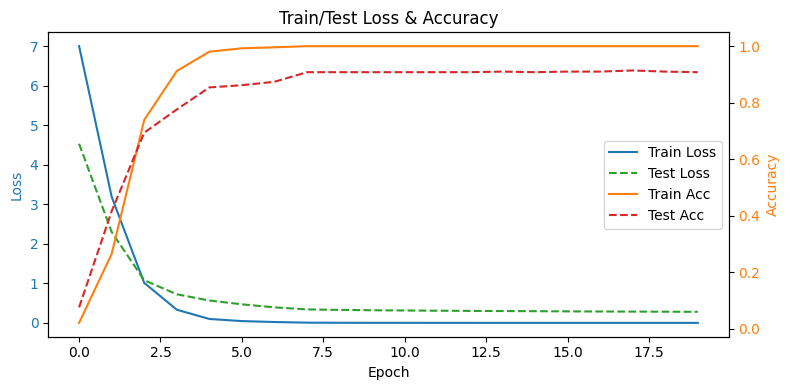

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

# Loss (왼쪽 y축)
ax1.plot(train_l, color='tab:blue', label='Train Loss')
ax1.plot(test_l, color='tab:green', label='Test Loss', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Accuracy (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(train_a, color='tab:orange', label='Train Acc')
ax2.plot(test_a, color='tab:red', label='Test Acc', linestyle='--')
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Train/Test Loss & Accuracy')
plt.tight_layout()
plt.show()


In [ ]:
delta 부분 이